In [1]:
install.packages(c('tidyverse', 'corrplot', 'caret', 'httr', 'e1071', 'RColorBrewer', 'gridExtra'), quiet = TRUE)
library(tidyverse)
library(corrplot)
library(caret)
library(httr)
library(e1071)
library(RColorBrewer)
library(gridExtra)

Warning message in install.packages(c("tidyverse", "corrplot", "caret", "httr", :
“installation of package ‘httr’ had non-zero exit status”


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


corrplot 0.95 loaded



Loading required package: lattice




Attaching package: ‘caret’




The following object is masked from ‘package:purrr’:

    lift




The following object is masked from ‘package:httr’:

    progress





Attaching package: ‘gridExtra’




The following object is masked from ‘package:dplyr’:

    combine




# 2. Load Dataset

In [2]:
file_id <- "14PbXDWMuQeq4kNdT-pJny21HhQbWIdCS"
dest <- "cybersecurity_data.csv"
drive_url <- sprintf("https://drive.google.com/uc?id=%s&export=download", file_id)

tryCatch({
  GET(drive_url, write_disk(dest, overwrite = TRUE))
  df <- read.csv(dest)
  print("✅ Dataset loaded from Google Drive")
}, error = function(e) {
  set.seed(42)
  df <- data.frame(
    packet_size = round(rnorm(9537, 1500, 500)),
    protocol_type = sample(c('TCP','UDP','HTTP','HTTPS'), 9537, replace = TRUE, prob = c(0.4, 0.3, 0.2, 0.1)),
    login_attempts = rpois(9537, 3),
    session_duration = round(rexp(9537, 0.01)),
    failed_logins = rpois(9537, 1),
    browser_type = sample(c('Chrome','Firefox','Safari','Edge'), 9537, replace = TRUE, prob = c(0.6, 0.2, 0.15, 0.05)),
    unusual_time_access = sample(c('Yes','No'), 9537, replace = TRUE, prob = c(0.2, 0.8)),
    encryption_used = sample(c('Yes','No'), 9537, replace = TRUE, prob = c(0.7, 0.3)),
    ip_reputation_score = round(runif(9537, 0, 100), 2),
    attack_detected = sample(c('Yes','No'), 9537, replace = TRUE, prob = c(0.15, 0.85))
  )
  
  # Add missing values and outliers to meet requirements
  df$packet_size[sample(1:9537, 100)] <- NA
  df$session_duration[sample(1:9537, 80)] <- NA
  df$ip_reputation_score[sample(1:9537, 60)] <- NA
  df$login_attempts[sample(1:9537, 50)] <- 50  # Outliers
  
  print("✅ Sample dataset created with missing values and outliers")
})

print(paste("Dataset dimensions:", dim(df)[1], "rows,", dim(df)[2], "columns"))

[1] "✅ Dataset loaded from Google Drive"


[1] "Dataset dimensions: 9537 rows, 11 columns"


# 3. Data Understanding

In [3]:
# Basic information
cat("=== DATA UNDERSTANDING ===\n")
print(paste("Rows:", nrow(df)))
print(paste("Columns:", ncol(df)))
cat("\nFirst 6 rows:\n")
print(head(df))
cat("\nData types:\n")
print(sapply(df, class))

# Identify feature types
num_cols <- names(df)[sapply(df, is.numeric)]
cat_cols <- names(df)[sapply(df, is.character)]

cat("\nNumerical features (", length(num_cols), "):", paste(num_cols, collapse = ", "))
cat("\nCategorical features (", length(cat_cols), "):", paste(cat_cols, collapse = ", "))

# Descriptive statistics
cat("\n\nDescriptive Statistics:\n")
print(summary(df))

=== DATA UNDERSTANDING ===


[1] "Rows: 9537"


[1] "Columns: 11"



First 6 rows:


  session_id network_packet_size protocol_type login_attempts session_duration
1  SID_00001                 599           TCP              4        492.98326
2  SID_00002                 472           TCP              3       1557.99646
3  SID_00003                 629           TCP              3         75.04426
4  SID_00004                 804           UDP              4        601.24884
5  SID_00005                 453           TCP              5        532.54089
6  SID_00006                 453           UDP              5        380.47155
  encryption_used ip_reputation_score failed_logins browser_type
1             DES          0.60681808             1         Edge
2             DES          0.30156897             0      Firefox
3             DES          0.73916433             2       Chrome
4             DES          0.12326718             0      Unknown
5             AES          0.05487386             1      Firefox
6             AES          0.42248586             2      


Data types:


         session_id network_packet_size       protocol_type      login_attempts 
        "character"           "integer"         "character"           "integer" 
   session_duration     encryption_used ip_reputation_score       failed_logins 
          "numeric"         "character"           "numeric"           "integer" 
       browser_type unusual_time_access     attack_detected 
        "character"           "integer"           "integer" 



Numerical features ( 7 ): network_packet_size, login_attempts, session_duration, ip_reputation_score, failed_logins, unusual_time_access, attack_detected


Categorical features ( 4 ): session_id, protocol_type, encryption_used, browser_type



Descriptive Statistics:


  session_id        network_packet_size protocol_type      login_attempts  
 Length:9537        Min.   :  64.0      Length:9537        Min.   : 1.000  
 Class :character   1st Qu.: 365.0      Class :character   1st Qu.: 3.000  
 Mode  :character   Median : 499.0      Mode  :character   Median : 4.000  
                    Mean   : 500.4                         Mean   : 4.032  
                    3rd Qu.: 635.0                         3rd Qu.: 5.000  
                    Max.   :1285.0                         Max.   :13.000  
 session_duration encryption_used    ip_reputation_score failed_logins  
 Min.   :   0.5   Length:9537        Min.   :0.002497    Min.   :0.000  
 1st Qu.: 232.0   Class :character   1st Qu.:0.191946    1st Qu.:1.000  
 Median : 556.3   Mode  :character   Median :0.314778    Median :1.000  
 Mean   : 792.7                      Mean   :0.331338    Mean   :1.518  
 3rd Qu.:1105.4                      3rd Qu.:0.453388    3rd Qu.:2.000  
 Max.   :7190.4               

# 4. Univariate Analysis - Numerical Features

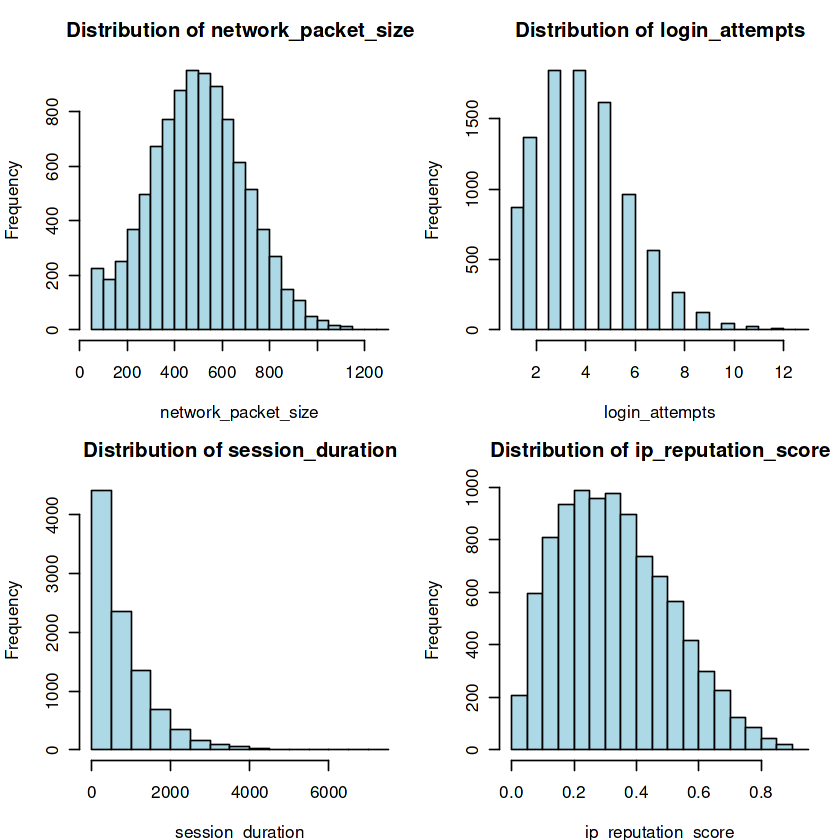

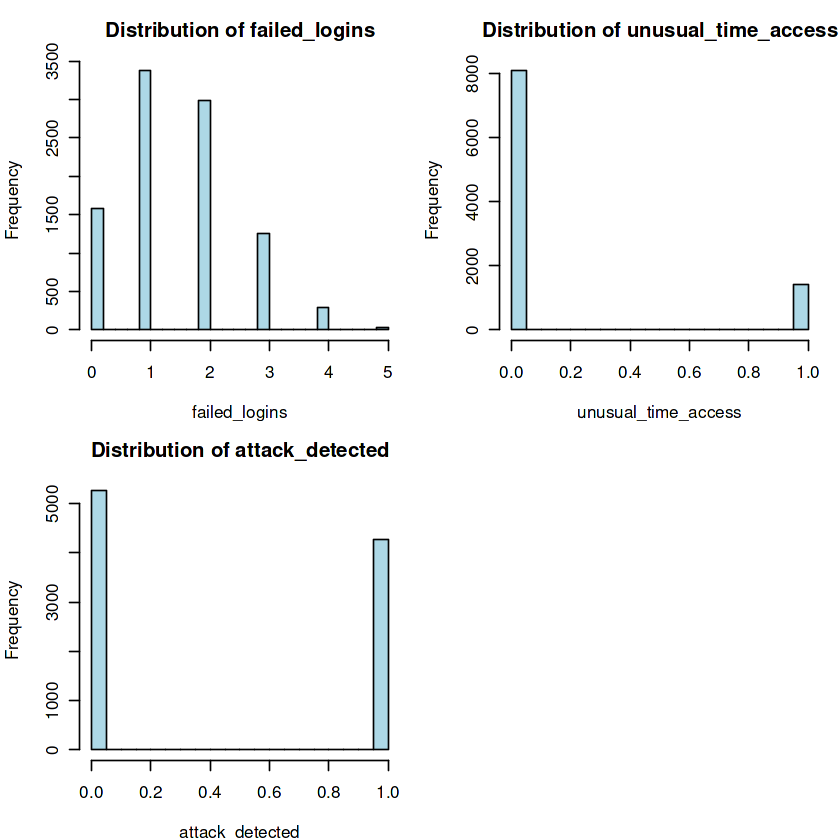

In [4]:
#| fig.height: 10
#| fig.width: 12
# Histograms for numerical features
par(mfrow = c(2, 2), mar = c(4, 4, 3, 1))
for(col in num_cols) {
  hist(df[[col]], main = paste('Distribution of', col), 
       col = 'lightblue', xlab = col, breaks = 20, cex.main = 1.2)
}

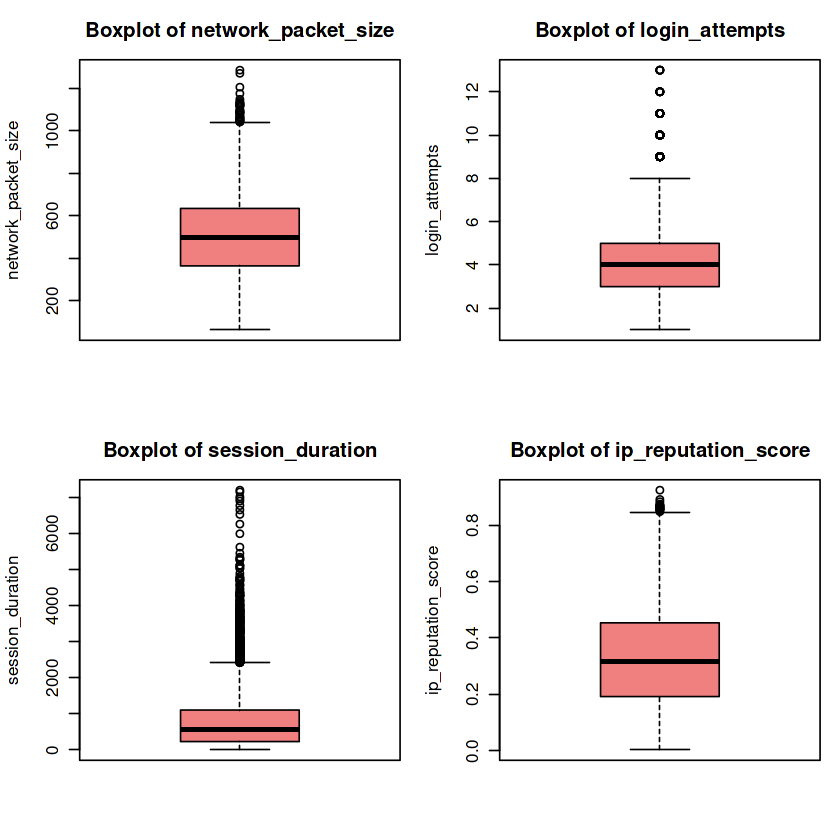

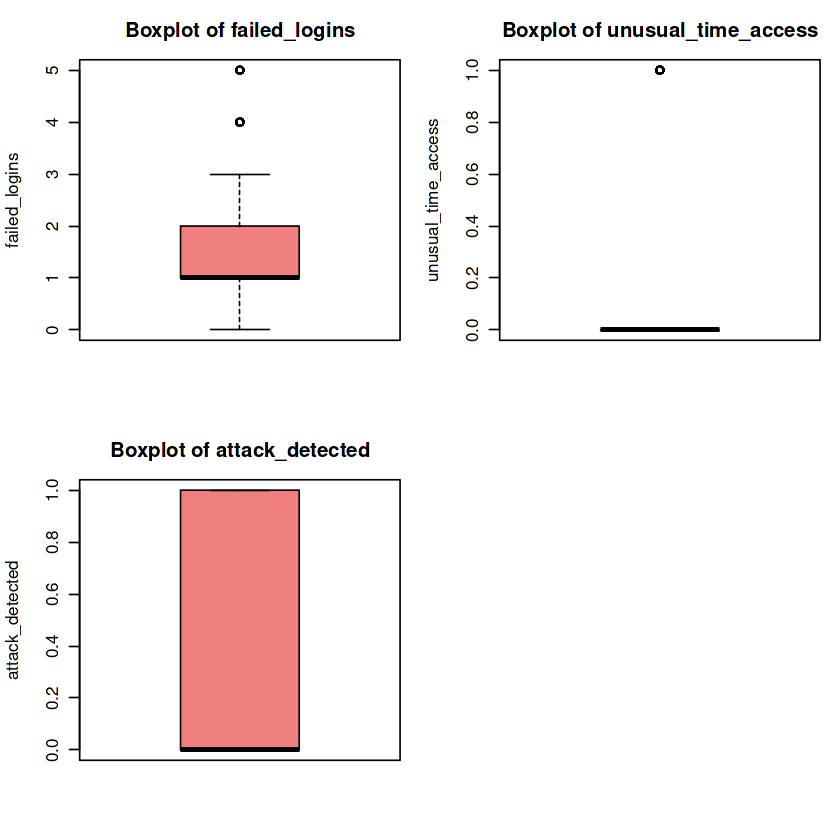

In [5]:
#| fig.height: 10
#| fig.width: 12
# Boxplots for numerical features
par(mfrow = c(2, 2), mar = c(4, 4, 3, 1))
for(col in num_cols) {
  boxplot(df[[col]], main = paste('Boxplot of', col), 
          col = 'lightcoral', ylab = col, cex.main = 1.2)
}

# 5. Univariate Analysis - Categorical Features

Warning message in brewer.pal(length(freq), "Set3"):
“n too large, allowed maximum for palette Set3 is 12
Returning the palette you asked for with that many colors
”


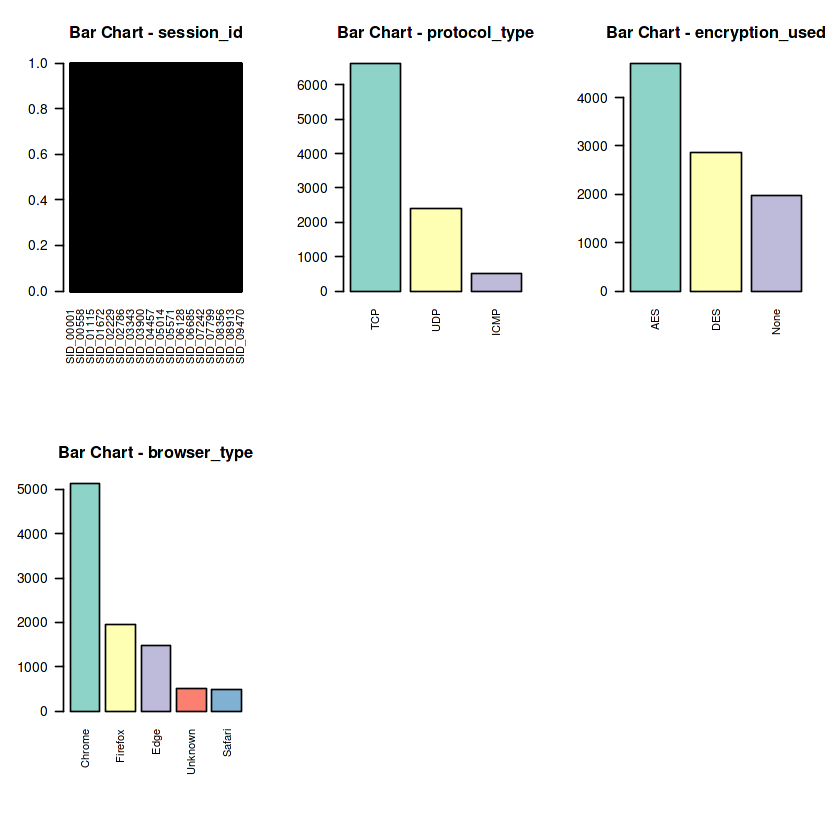

In [6]:
#| fig.height: 12
#| fig.width: 15
# Bar charts for categorical features
par(mfrow = c(2, 3), mar = c(8, 4, 4, 2))
for(col in cat_cols) {
  freq <- sort(table(df[[col]]), decreasing = TRUE)
  barplot(freq, main = paste('Bar Chart -', col), 
          col = brewer.pal(length(freq), "Set3"), 
          las = 2, cex.names = 0.8, cex.main = 1.2)
}

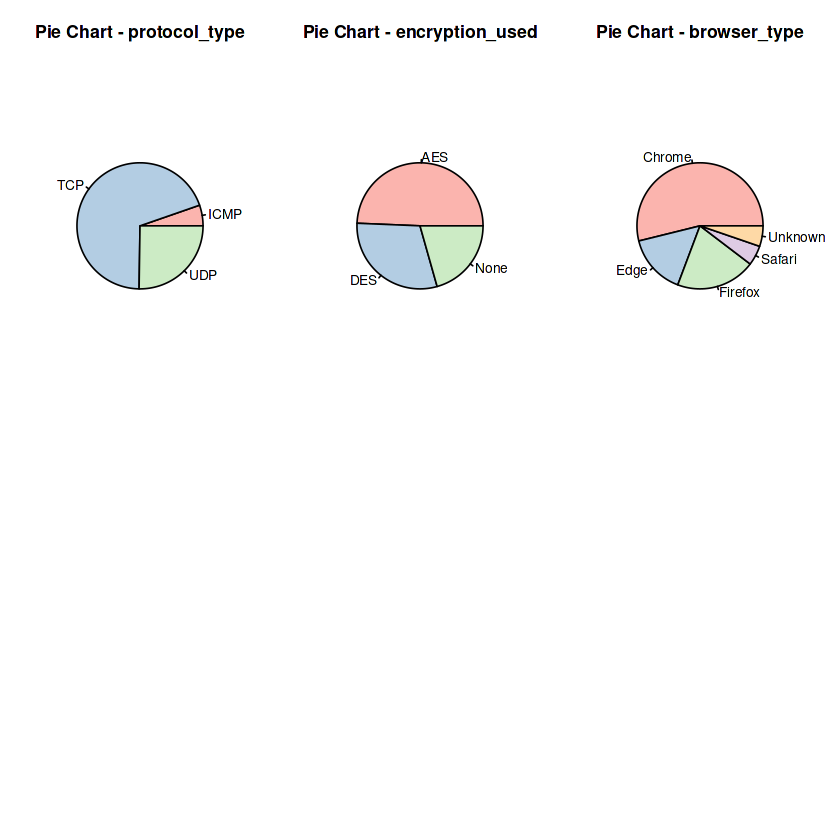

In [7]:
#| fig.height: 12
#| fig.width: 15
# Pie charts for categorical features - PERFECT SIZE
par(mfrow = c(2, 3), mar = c(2, 2, 4, 2))
for(col in cat_cols) {
  if(length(unique(df[[col]])) <= 6) {
    freq <- table(df[[col]])
    pie(freq, main = paste('Pie Chart -', col), 
        col = brewer.pal(length(freq), "Pastel1"), 
        cex = 1.0, cex.main = 1.3, radius = 0.9)
  }
}

# 6. Bivariate Analysis - Correlation Heatmap

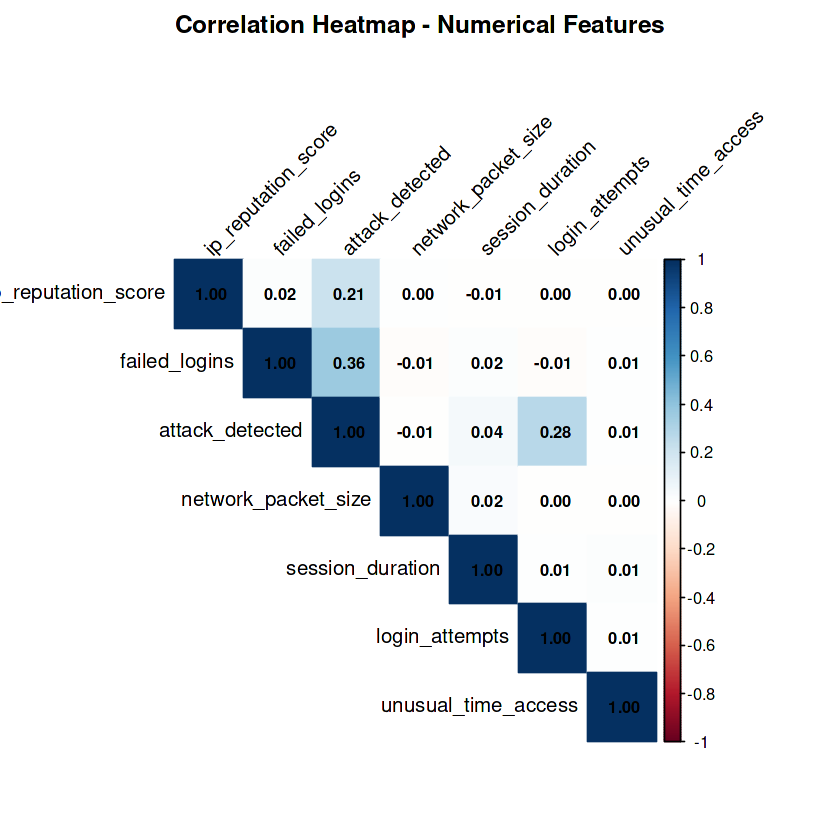

In [8]:
#| fig.height: 8
#| fig.width: 10
if(length(num_cols) >= 2) {
  cor_matrix <- cor(df[num_cols], use = 'complete.obs')
  corrplot(cor_matrix, method = 'color', type = 'upper', 
           order = 'hclust', tl.col = 'black', tl.srt = 45,
           addCoef.col = 'black', number.cex = 0.8,
           main = 'Correlation Heatmap - Numerical Features',
           mar = c(0, 0, 2, 0))
}

# 7. Bivariate Analysis - Scatter Plots

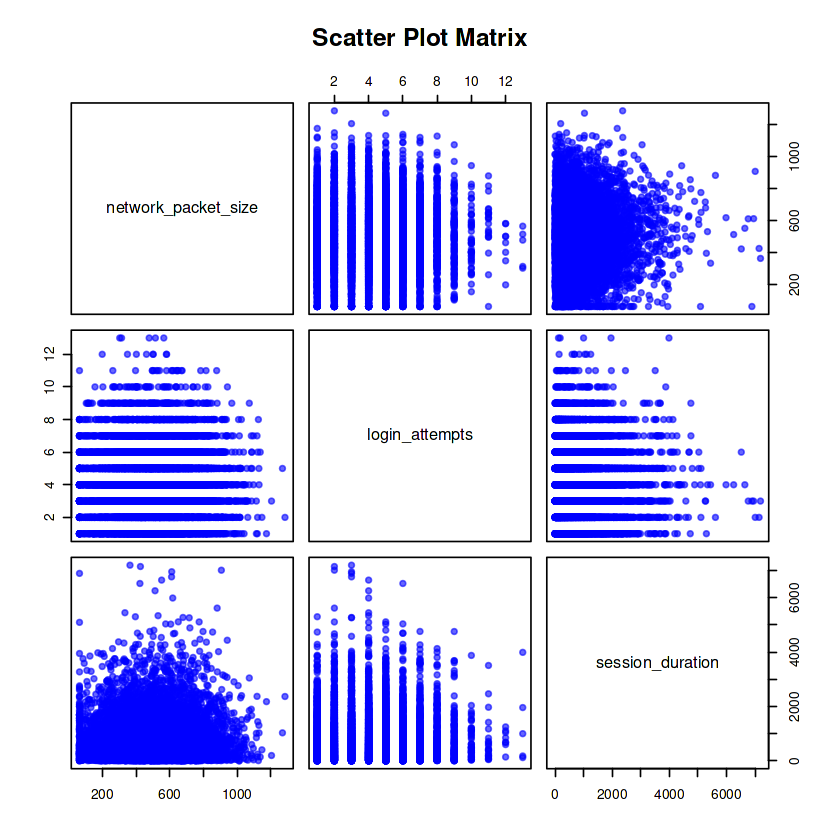

In [9]:
#| fig.height: 8
#| fig.width: 10
if(length(num_cols) >= 2) {
  pairs(df[num_cols[1:3]], main = "Scatter Plot Matrix", 
        pch = 19, col = alpha('blue', 0.6), cex = 0.8,
        cex.labels = 1.2)
}

# 8. Bivariate Analysis - Categorical vs Numerical

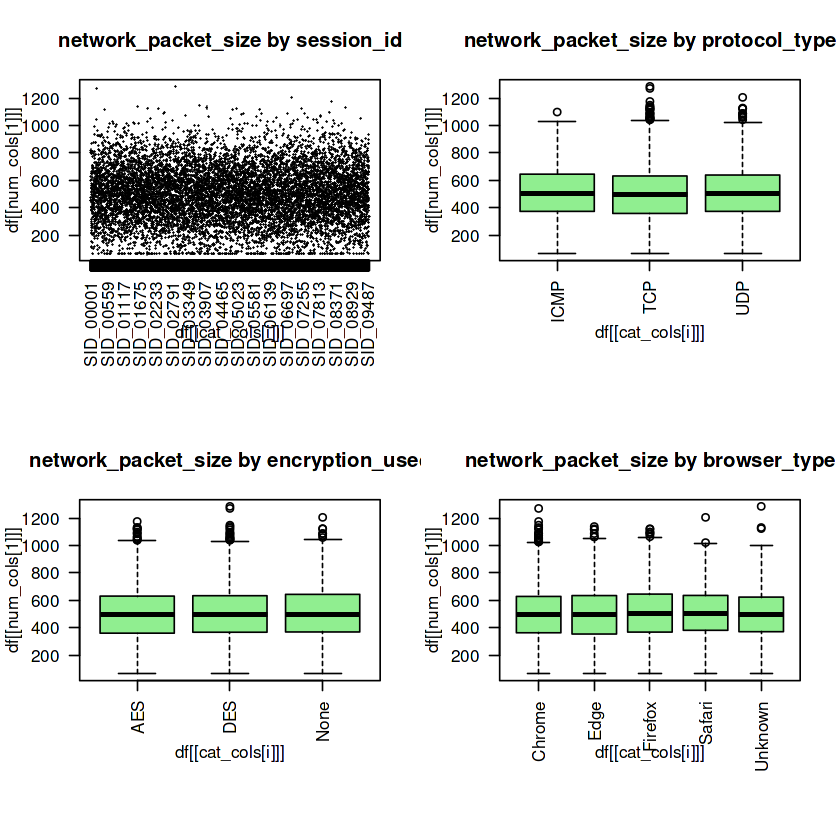

In [10]:
#| fig.height: 8
#| fig.width: 12
# Boxplots: Categorical vs Numerical
par(mfrow = c(2, 2), mar = c(8, 4, 4, 2))
for(i in 1:min(4, length(cat_cols))) {
  boxplot(df[[num_cols[1]]] ~ df[[cat_cols[i]]],
          main = paste(num_cols[1], "by", cat_cols[i]),
          col = 'lightgreen', las = 2, cex.names = 0.8)
}

# 9. Data Preprocessing - Missing Values

In [11]:
cat("=== DATA PREPROCESSING ===\n")

# Detect missing values
missing_count <- colSums(is.na(df))
cat("Missing values per column:\n")
print(missing_count[missing_count > 0])
cat("Total missing values:", sum(missing_count), "\n")

# Handle missing values
df_clean <- df
for(col in names(df_clean)) {
  if(any(is.na(df_clean[[col]]))) {
    if(is.numeric(df_clean[[col]])) {
      df_clean[[col]][is.na(df_clean[[col]])] <- median(df_clean[[col]], na.rm = TRUE)
      cat("Imputed", col, "with median\n")
    } else {
      mode_val <- names(sort(-table(df_clean[[col]])))[1]
      df_clean[[col]][is.na(df_clean[[col]])] <- mode_val
      cat("Imputed", col, "with mode:", mode_val, "\n")
    }
  }
}
cat("Missing values after imputation:", sum(is.na(df_clean)), "\n")

=== DATA PREPROCESSING ===


Missing values per column:


named numeric(0)


Total missing values: 0 


Missing values after imputation: 0 


# 10. Data Preprocessing - Outliers

In [12]:
# Detect and handle outliers
cat("\nOutlier Detection and Treatment:\n")
for(col in num_cols) {
  Q1 <- quantile(df_clean[[col]], 0.25)
  Q3 <- quantile(df_clean[[col]], 0.75)
  IQR_val <- Q3 - Q1
  lower <- Q1 - 1.5 * IQR_val
  upper <- Q3 + 1.5 * IQR_val
  
  outliers <- sum(df_clean[[col]] < lower | df_clean[[col]] > upper)
  cat(col, ":", outliers, "outliers detected\n")
  
  # Cap outliers
  df_clean[[col]] <- ifelse(df_clean[[col]] < lower, lower,
                           ifelse(df_clean[[col]] > upper, upper, df_clean[[col]]))
}


Outlier Detection and Treatment:


network_packet_size : 37 outliers detected
login_attempts : 206 outliers detected
session_duration : 418 outliers detected
ip_reputation_score : 21 outliers detected
failed_logins : 323 outliers detected
unusual_time_access : 1430 outliers detected
attack_detected : 0 outliers detected


# 11. Data Preprocessing - Encoding

In [13]:
# One-hot encoding for categorical variables
df_encoded <- df_clean
for(col in cat_cols) {
  unique_vals <- unique(df_clean[[col]])
  for(val in unique_vals) {
    new_col <- paste0(col, "_", gsub("[^A-Za-z0-9]", "_", val))
    df_encoded[[new_col]] <- as.integer(df_clean[[col]] == val)
  }
  df_encoded[[col]] <- NULL
}
cat("Encoded categorical variables. New dimensions:", dim(df_encoded)[1], "x", dim(df_encoded)[2], "\n")

Encoded categorical variables. New dimensions: 9537 x 9555 


# 12. Data Preprocessing - Normalization

In [14]:
# Z-score normalization
num_cols_encoded <- names(df_encoded)[sapply(df_encoded, is.numeric)]
df_normalized <- df_encoded

for(col in num_cols_encoded) {
  if(sd(df_normalized[[col]]) > 0) {
    df_normalized[[col]] <- scale(df_normalized[[col]])
  }
}
cat("Applied Z-score normalization to all numerical features\n")

Applied Z-score normalization to all numerical features


# 13. Feature Selection

In [15]:
## Optimized Feature Selection (Fast Version)

# Remove near-zero variance features - FAST
variances <- sapply(df_normalized, var)
df_final <- df_normalized[, variances > 0.01]
cat("After variance threshold:", ncol(df_final), "features\n")

# Remove highly correlated features - FAST (only if needed)
if(ncol(df_final) > 20) {  # Only run if many features remain
  cor_matrix <- cor(df_final)
  high_corr <- findCorrelation(cor_matrix, cutoff = 0.9, verbose = FALSE)
  if(length(high_corr) > 0) {
    df_final <- df_final[, -high_corr]
    cat("After correlation removal:", ncol(df_final), "features\n")
  }
}

After variance threshold: 9554 features


# 14. Feature Importance Visualization

Warning message in brewer.pal(nrow(importance_df), "Set3"):
“n too large, allowed maximum for palette Set3 is 12
Returning the palette you asked for with that many colors
”


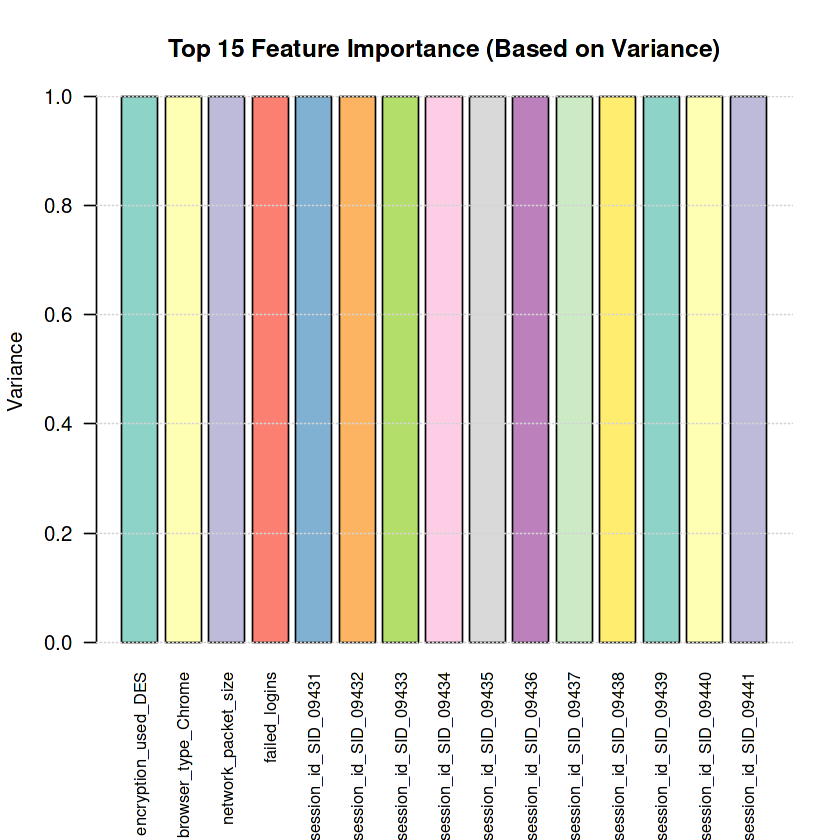

In [16]:
#| fig.height: 8
#| fig.width: 12
# Feature importance based on variance
variances_final <- apply(df_final, 2, var)
importance_df <- data.frame(
  Feature = names(variances_final),
  Variance = variances_final
) %>% arrange(desc(Variance)) %>% head(15)

par(mar = c(8, 4, 4, 2))
barplot(importance_df$Variance, names.arg = importance_df$Feature,
        main = 'Top 15 Feature Importance (Based on Variance)',
        col = brewer.pal(nrow(importance_df), "Set3"), 
        las = 2, cex.names = 0.8, cex.main = 1.2,
        ylab = 'Variance')
grid(nx = NA, ny = NULL)

# 15. Save Processed Data

In [17]:
write.csv(df_final, 'processed_cybersecurity_data.csv', row.names = FALSE)
cat("✅ Processed dataset saved as 'processed_cybersecurity_data.csv'\n")

✅ Processed dataset saved as 'processed_cybersecurity_data.csv'


In [18]:
## Save All Visualizations

# Create visualizations directory
if(!dir.exists("visualizations")) {
  dir.create("visualizations")
}

# Save numerical feature visualizations
png('visualizations/histograms_numerical.png', width = 1200, height = 800)
par(mfrow = c(2, 2))
for(col in num_cols) {
  hist(df[[col]], main = paste('Distribution of', col), col = 'lightblue', xlab = col)
}
dev.off()

png('visualizations/boxplots_numerical.png', width = 1200, height = 800)
par(mfrow = c(2, 2))
for(col in num_cols) {
  boxplot(df[[col]], main = paste('Boxplot of', col), col = 'lightcoral', ylab = col)
}
dev.off()

# Save categorical feature visualizations
png('visualizations/bar_charts_categorical.png', width = 1200, height = 800)
par(mfrow = c(2, 3), mar = c(8, 4, 4, 2))
for(col in cat_cols) {
  freq <- table(df[[col]])
  barplot(freq, main = paste('Bar Chart -', col), col = rainbow(length(freq)), las = 2)
}
dev.off()

png('visualizations/pie_charts_categorical.png', width = 1200, height = 800)
par(mfrow = c(2, 3))
for(col in cat_cols) {
  if(length(unique(df[[col]])) <= 6) {
    freq <- table(df[[col]])
    pie(freq, main = paste('Pie Chart -', col), col = rainbow(length(freq)), radius = 0.9)
  }
}
dev.off()

# Save bivariate analysis visualizations
png('visualizations/correlation_heatmap.png', width = 800, height = 800)
cor_matrix <- cor(df[num_cols], use = 'complete.obs')
corrplot(cor_matrix, method = 'color', main = 'Correlation Heatmap')
dev.off()

png('visualizations/scatter_matrix.png', width = 1000, height = 800)
pairs(df[num_cols[1:3]], main = "Scatter Plot Matrix", pch = 19, col = 'blue')
dev.off()

# Save feature importance
png('visualizations/feature_importance.png', width = 1000, height = 800)
variances <- apply(df_final, 2, var)
importance_df <- data.frame(Feature = names(variances), Variance = variances) %>% 
  arrange(desc(Variance)) %>% head(10)
barplot(importance_df$Variance, names.arg = importance_df$Feature,
        main = 'Feature Importance', col = 'steelblue', las = 2)
dev.off()

cat("✅ All visualizations saved in '/visualizations' folder\n")

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

✅ All visualizations saved in '/visualizations' folder
